<img src="http://datapark.io/img/logo.png" alt="datpark" width="35%" align="right" border="0"><br>

# TsTables &ndash; High Frequency Times Series Data with PyTables

**TsTables** is a Python library by Andy Fiedler built on top of the popular ``PyTables`` HDF5 database library. It is meant to handle large amounts of **high frequency time series data** in **append once, retrieve many times** scenarios (cf. [Gihub page](https://github.com/afiedler/tstables)). The focus lies on retrieving chunks of data from large data sets as quickly as possible.

## Sample Time Series Data

In [1]:
import numpy as np
import pandas as pd
import tables as tb
import tstables as tstb
from datetime import datetime 
import matplotlib as mpl
mpl.use('agg')
import seaborn as sns; sns.set()
%matplotlib inline

Let us generate a **decent amount of sample data points**.

In [2]:
no = 5000000
co = 3
dt = 1. / (12 * 30 * 24 * 60)
vol = 0.2

We generate **one second** data.

In [3]:
dr = pd.date_range('2014-1-1', periods=no, freq='1s')

In [4]:
dr

DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 00:00:01',
               '2014-01-01 00:00:02', '2014-01-01 00:00:03',
               '2014-01-01 00:00:04', '2014-01-01 00:00:05',
               '2014-01-01 00:00:06', '2014-01-01 00:00:07',
               '2014-01-01 00:00:08', '2014-01-01 00:00:09', 
               ...
               '2014-02-27 20:53:10', '2014-02-27 20:53:11',
               '2014-02-27 20:53:12', '2014-02-27 20:53:13',
               '2014-02-27 20:53:14', '2014-02-27 20:53:15',
               '2014-02-27 20:53:16', '2014-02-27 20:53:17',
               '2014-02-27 20:53:18', '2014-02-27 20:53:19'],
              dtype='datetime64[ns]', length=5000000, freq='S', tz=None)

**In memory** generation is quite quick.

In [5]:
%%time
da = 100 * np.exp(np.cumsum(-0.5 * vol ** 2 * dt +
        vol * np.sqrt(dt) * np.random.standard_normal((no, co)), axis=0))
da[0] = 100

CPU times: user 1.29 s, sys: 87.1 ms, total: 1.38 s
Wall time: 1.38 s


In [6]:
df = pd.DataFrame(da, index=dr, columns=['ts1', 'ts2', 'ts3'])

In [7]:
df.count()

ts1    5000000
ts2    5000000
ts3    5000000
dtype: int64

The **starting values** of the three time series.

In [8]:
df.head()

,ts1,ts2,ts3
2014-01-01 00:00:00,100.000000,100.000000,100.000000
2014-01-01 00:00:01,99.993741,100.044124,100.008247
2014-01-01 00:00:02,99.984598,100.046623,99.977645
2014-01-01 00:00:03,100.006479,100.048659,99.979245
2014-01-01 00:00:04,100.018308,100.057601,99.969766


And a **plot** of the time series data (every 100000th point).

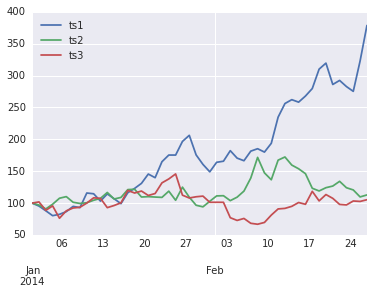

In [9]:
df[::100000].plot()

## Storage and Retrieval with TsTables

To store the time series data in a **PyTables table** we first define the **table structure**.

In [10]:
class TS(tb.IsDescription):
    timestamp = tb.Int64Col(pos=0)
    ts1 = tb.Float64Col(pos=1)
    ts2 = tb.Float64Col(pos=1)
    ts3 = tb.Float64Col(pos=1)

Second, open a database file and **create the table object**.

In [11]:
h5 = tb.open_file('ts.h5','w')

TsTables adds a new function **``create_ts``** to PyTables.

In [12]:
ts = h5.create_ts('/','TS', TS)

Third, we **append the time series data** to the table object.

In [13]:
%time ts.append(df)

CPU times: user 528 ms, sys: 261 ms, total: 789 ms
Wall time: 788 ms


In [14]:
ls -n *.h5

-rw-r--r-- 1 0 0 157037848 Aug  7 15:28 ts.h5


The strength of TsTables lies in retrieving **chunks of time series data** defined by a **start date and an end date** (which obviously is a typical case in finance, e.g. in backtesting strategies or risk management).

In [15]:
read_start_dt = datetime(2014, 2, 1, 0, 0)
read_end_dt = datetime(2014, 2, 5, 23, 59)

TsTables tries to make such an operation **as fast as possible**.

In [16]:
%time rows = ts.read_range(read_start_dt, read_end_dt)

CPU times: user 56.2 ms, sys: 12 ms, total: 68.3 ms
Wall time: 66.9 ms


In [17]:
%timeit rows = ts.read_range(read_start_dt, read_end_dt)

10 loops, best of 3: 44.4 ms per loop


Conveniently, the **returned object is a pandas DataFrame**.

In [18]:
rows.count()

ts1    431941
ts2    431941
ts3    431941
dtype: int64

In [19]:
rows.head()

,ts1,ts2,ts3
2014-02-01 00:00:00,164.400347,116.808093,102.777669
2014-02-01 00:00:01,164.408910,116.826512,102.739382
2014-02-01 00:00:02,164.452665,116.777747,102.727334
2014-02-01 00:00:03,164.546535,116.790035,102.709615
2014-02-01 00:00:04,164.559488,116.808340,102.715006


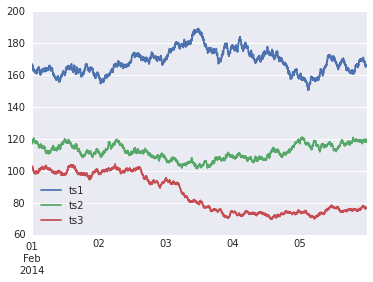

In [20]:
rows[::100].plot()

In [21]:
h5.close()

In [22]:
!rm ts.h5

<img src="http://datapark.io/img/logo.png" alt="datapark" width="35%" align="right" border="0"><br>

<a href="http://datapark.io" target="_blank">datapark.io</a> | <a href="http://twitter.com/dataparkio" target="_blank">@dataparkio</a> | <a href="mailto:team@datapark.io">team@datapark.io</a>